In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import glob
from mpl_toolkits.basemap import Basemap

data_dir = '/datasets/NOAA_SST/'
#load(data_dir + “noaa_gsod/…/file”
t0 = time.time()
data = pd.read_pickle(data_dir+'noaa_gsod/Combined_noaa_gsod') # load weather data
stations = pd.read_pickle(data_dir+'noaa_gsod.stations') # load station data

# # USE ONLY 2008-2018 # #
data = data.loc[data.index >= pd.Timestamp(2008, 1, 1)]
data = data.drop(columns=['yr','year','da','mo']) # don't need these anymore
print(time.time()-t0)

# # SELECT RANDOM STATION # #
np.random.seed(3)
rs = np.unique(data['stn'].values) # find unique stations with data
rand_stat = rs[randint(len(rs))] # pick a random station

# # ideally we should check < len(np.unique(data.index)), but many are shorter
while (len(data.loc[data['stn'] == rand_stat]) < 3650): # If not enough data
    if len(stations.loc[stations['usaf'] == rand_stat]): # If station info available
        if (stations.loc[stations['usaf'] == rand_stat].iloc[0]['wban'] != '99999'): # If station number not unique
            rand_stat = rs[randint(len(rs))] # get a new station
    else:
        rand_stat = rs[randint(len(rs))] # get a new station

select_station = stations.loc[stations['usaf'] == rand_stat] # get location, etc, for random station



features = data.loc[data['stn'] == rand_stat] # pick weather at random station
features = features.drop(columns='stn')
features = features.sort_index()
select_station.head() # see where it is

features.head()

### Time-shift the data

features = features.drop(columns='wdsp') # Drop maximum wind speed that day
columns = features.columns # weather variables

for co in columns:
    # one day lag
    features[co + '_lag1'] = features[co].shift(periods=1)
    
    # two days lag
    features[co + '_lag2'] = features[co].shift(periods=2)
    
    # three days lag
    features[co + '_lag3'] = features[co].shift(periods=3)
features = features.iloc[3:]
print(str(len(features)) + ' samples, ' + str(len(features.columns)) + ' features.')
features.head()

# View station locations
fig = plt.figure(figsize=(18.5, 10.5))
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180, resolution='l')
m.drawmapboundary(fill_color='xkcd:lightblue')
m.fillcontinents(color='xkcd:green',lake_color='xkcd:lightblue')
m.drawmeridians(np.arange(-180.,180.,30.),labels=[True,False,False,True])
m.drawparallels(np.arange(-90.,90,30.),labels=[False,True,True,False])
lon = select_station['lon'].tolist()
lat = select_station['lat'].tolist()
#xpt,ypt = m(lon,lat)
m.plot(lon, lat,'r+') 
#m.plot(179.75, -19.133, 'ro')
plt.show()

### Create train/val/test

ylabel = features['mxpsd'] # use today's wind speed as the label
features = features.drop(columns='mxpsd') # don't put it in training data!!

# Use 20% test split (80% training + validation)
ntrain = int(len(features)*0.8)
x_test = features.iloc[ntrain:,:]
y_test = ylabel[ntrain:]
indices = np.arange(ntrain)

# Split remaining 80% into training-validation sets (of original data)
x_train, x_val, y_train, y_val = train_test_split(features.iloc[0:ntrain,:], ylabel[0:ntrain],
                                                  test_size=0.2, random_state=1)

# Scale features. Fit scaler on training only.
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

25.062467336654663
3926 samples, 24 features.


<Figure size 1850x1050 with 1 Axes>

### Predict with Random Forest

In [2]:
# # Create, train, and predict random forest here # #
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train);

### Test Data

Mean Absolute Error: 1.84  miles per hour.


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


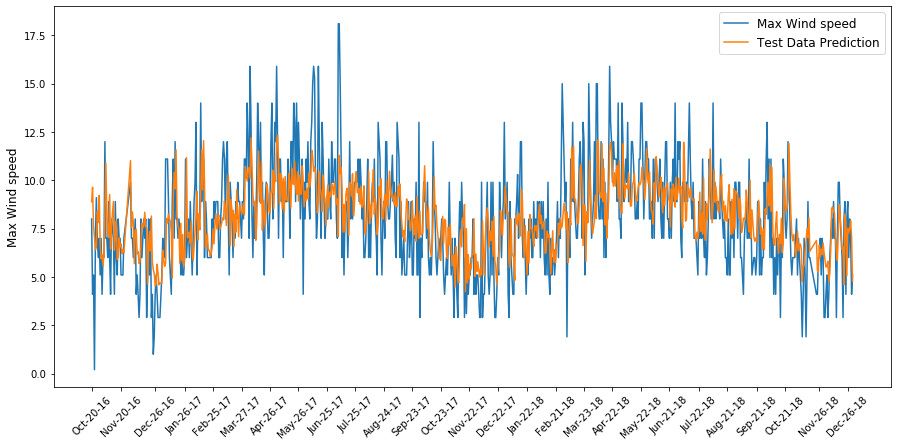

In [3]:
y_predictions = rf.predict(x_test)
errors = abs(y_predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), ' miles per hour.')
###plot
# plot predictions
plt.figure(figsize=(15,7))
plt.plot(features.iloc[ntrain:].index,y_test) # plot actual temperature
plt.plot(features.iloc[ntrain:].index, y_predictions) # plot predicted temperature
plt.xticks(features.iloc[ntrain:].index[::30], rotation = 45) # set xticks to monthly

myFmt = mdates.DateFormatter('%b-%d-%y')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Max Wind speed', fontsize=12)
plt.legend(('Max Wind speed','Test Data Prediction'), fontsize=12, loc=1)
plt.show()

### Validation Data Mean Absolute Error and Accuracy

Mean Absolute Error: 1.79  miles per hour.
Accuracy: 73.61 %.


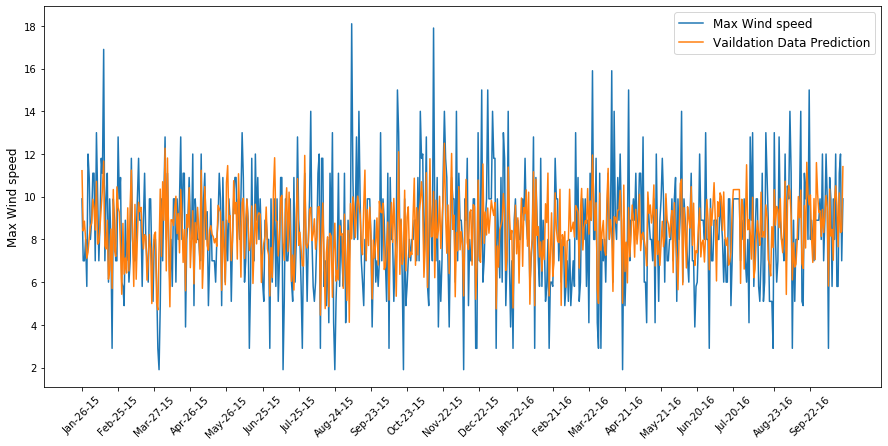

In [4]:
# Use the forest's predict method on the test data
y_predictions = rf.predict(x_val)
# Calculate the absolute errors
errors = abs(y_predictions - y_val)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), ' miles per hour.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_val)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

###plot
# plot predictions
plt.figure(figsize=(15,7))
ValidNum= int(ntrain*0.8)

plt.plot(features.iloc[range(ValidNum,ntrain)].index,y_val) # plot actual temperature
plt.plot(features.iloc[range(ValidNum,ntrain)].index, y_predictions) # plot predicted temperature
plt.xticks(features.iloc[range(ValidNum,ntrain)].index[::30], rotation = 45) # set xticks to monthly

myFmt = mdates.DateFormatter('%b-%d-%y')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Max Wind speed', fontsize=12)
plt.legend(('Max Wind speed','Vaildation Data Prediction'), fontsize=12, loc=1)
plt.show()

### Training Data Mean Absolute Error and Accuracy

Mean Absolute Error: 0.64 miles per hour.
Accuracy: 91.0211291752 %.


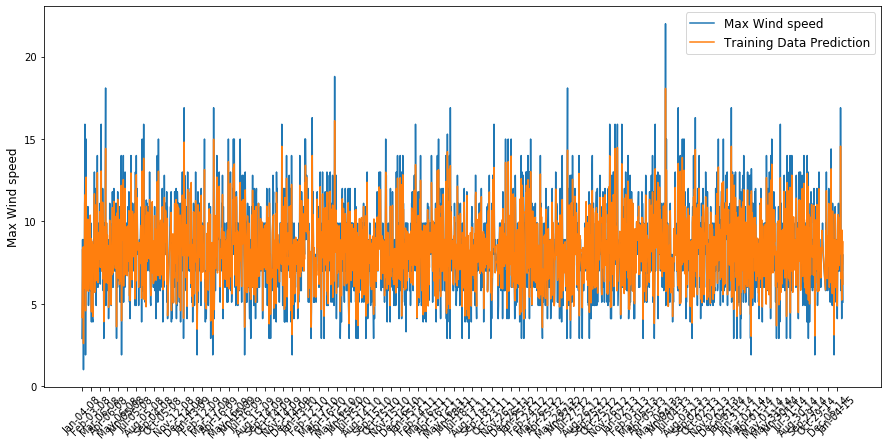

In [5]:
# Use the forest's predict method on the test data
y_predictions = rf.predict(x_train)
# Calculate the absolute errors
errors = abs(y_predictions - y_train)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'miles per hour.')

# Calculate mean absolute percentage error (MAPE)
mape = abs(100 * (errors / y_train))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 10), '%.')


###plot
# plot predictions
plt.figure(figsize=(15,7))
ValidNum= int(ntrain*0.8)
plt.plot(features.iloc[:ValidNum].index,y_train) # plot actual temperature
plt.plot(features.iloc[:ValidNum].index, y_predictions) # plot predicted temperature
plt.xticks(features.iloc[:ValidNum].index[::30], rotation = 45) # set xticks to monthly

myFmt = mdates.DateFormatter('%b-%d-%y')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Max Wind speed', fontsize=12)
plt.legend(('Max Wind speed','Training Data Prediction'), fontsize=12, loc=1)
plt.show()

### Feature Importance Part

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


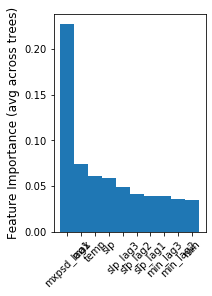

In [6]:
nfeatures = 10
fi = rf.feature_importances_ # get feature importances
fi_sort = np.argsort(fi)[::-1] # sort importances most to least
plt.subplot(1,2,2)
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]], width=1, \
        tick_label=features.columns.values[[fi_sort[0:nfeatures]]]) # plot features importances
plt.ylabel('Feature Importance (avg across trees)', fontsize=12)
plt.xticks(rotation = 45)
plt.show()